In [139]:
import tensorflow as tf
import yfinance as yf
import matplotlib.pyplot as plt
from tensorflow import keras 
from sklearn.model_selection import TimeSeriesSplit


<Axes: xlabel='Date'>

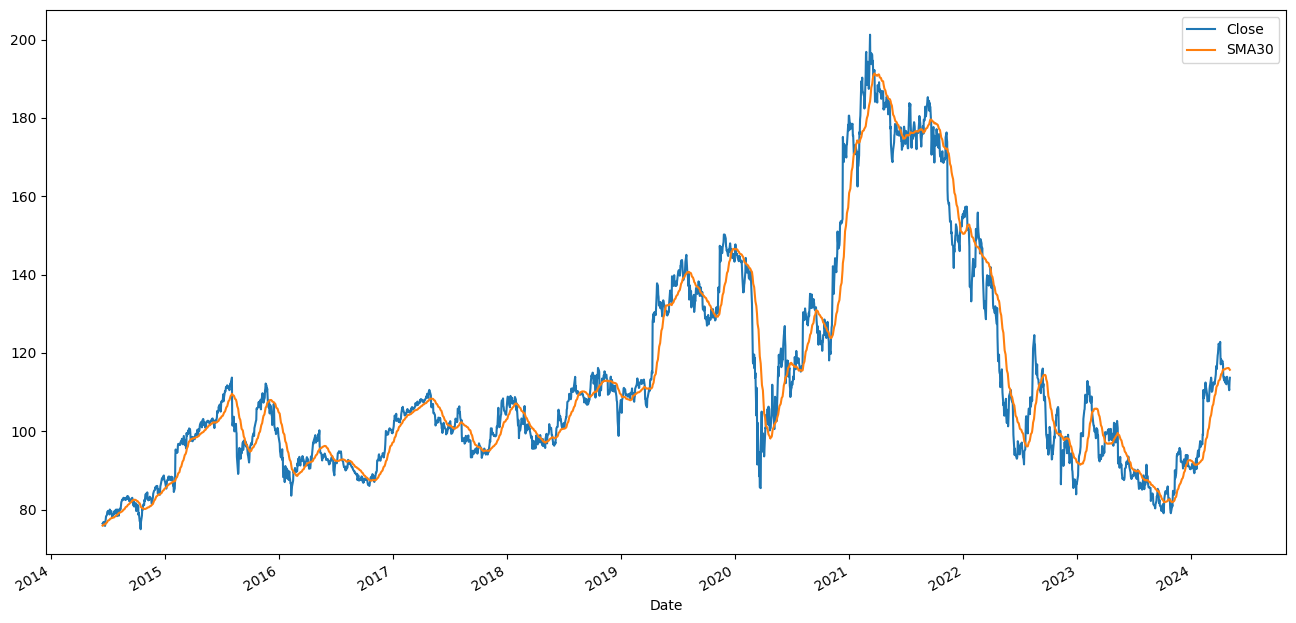

In [140]:
msft = yf.Ticker("DIS")

hist = msft.history(period="10y")

hist = hist.drop(columns=["Open", "High", "Low","Stock Splits", "Dividends"])

# Calculate 30-day Simple Moving Average (SMA)
hist['SMA30'] = hist['Close'].rolling(30).mean()
 
# Remove NULL values
hist.dropna(inplace=True)

hist.head()
#plot = plt.plot(hist["Close"])
hist[['Close', 'SMA30']].plot(figsize=(16, 8))


## Dividing data into training and test

In [141]:
ts_cv = TimeSeriesSplit(
    n_splits=10,  # to keep the notebook fast enough on common laptops
    gap=48  # 2 days data gap between train and test  # for 2 or 3 digits of precision in scores
)

# Just trains off first year, overwritten by next block
all_splits = list(ts_cv.split(hist, hist["Close"] ))
train_idx, test_idx = all_splits[0]
X_train, X_test = hist.iloc[train_idx], hist.iloc[test_idx]
y_train, y_test = hist["Close"].iloc[train_idx], hist["Close"].iloc[test_idx]

In [142]:
#train on first 9 years, predict the last

X_train = hist[:2250]
X_test = hist[2250:2518]

y_train = hist["Close"][:2250]
y_test = hist["Close"][2250:2518]

print(X_test)
#Uncomment for 30 days of predictions
#X_test = hist[2250:2280]
#y_test = hist["Close"][2250:2280]

                                Close    Volume       SMA30
Date                                                       
2023-05-23 00:00:00-04:00   89.528221  14778700   97.303545
2023-05-24 00:00:00-04:00   88.780655  15350800   97.008838
2023-05-25 00:00:00-04:00   87.853676  13605800   96.586880
2023-05-26 00:00:00-04:00   88.003189  12892700   96.201138
2023-05-30 00:00:00-04:00   87.534714  14800700   95.786489
...                               ...       ...         ...
2024-04-29 00:00:00-04:00  112.080002   7151200  116.150000
2024-04-30 00:00:00-04:00  111.099998   8156600  116.058333
2024-05-01 00:00:00-04:00  110.480003   6338400  115.924000
2024-05-02 00:00:00-04:00  112.620003   6799800  115.796000
2024-05-03 00:00:00-04:00  113.660004   7389519  115.694667

[239 rows x 3 columns]


In [143]:
y_train.head(3)

Date
2014-06-16 00:00:00-04:00    76.413307
2014-06-17 00:00:00-04:00    76.284889
2014-06-18 00:00:00-04:00    76.670143
Name: Close, dtype: float64

In [144]:

# y data shift up one to predict tmrws close 
y_test = y_test.shift(-1,axis=0)
y_train = y_train.shift(-1,axis=0)
y_train.head(3)

#remove last x value in train and test and empty y value at end
X_train.drop(X_train.tail(1).index,
        inplace = True)

X_test.drop(X_test.tail(1).index,
        inplace = True)

y_test.drop(y_test.tail(1).index,
        inplace = True)

y_train.drop(y_train.tail(1).index,
        inplace = True)

/var/folders/9x/hp4yd9t517q0b2m13pghld080000gn/T/ipykernel_11165/1518231340.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.drop(X_train.tail(1).index,
/var/folders/9x/hp4yd9t517q0b2m13pghld080000gn/T/ipykernel_11165/1518231340.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.drop(X_test.tail(1).index,


## Recuring Nueral Network - Long short term memory layers
Sequential - linear layers.  
Dense: standard NN layer
LSTM:layer used for time series data
Dropout: randomly ignore neurons to avoid overfitting

In [145]:

model = keras.models.Sequential() 
model.add(keras.layers.LSTM(units=64, 
                            return_sequences=True, 
                            input_shape=(X_train.shape[1], 1))) 
model.add(keras.layers.LSTM(units=64)) 
model.add(keras.layers.Dense(32)) 
model.add(keras.layers.Dropout(0.5)) 
model.add(keras.layers.Dense(1)) 
model.summary 

/Users/natebowers/Documents/ATCS/TradingML/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


<bound method Model.summary of <Sequential name=sequential_10, built=True>>

In [146]:
model.compile(optimizer='adam', 
              loss='mean_squared_error') 
history = model.fit(X_train, 
                    y_train, 
                    epochs=50)

Epoch 1/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 12826.6338
Epoch 2/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3333.9343
Epoch 3/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1200.4125
Epoch 4/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1157.7292
Epoch 5/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1094.7494
Epoch 6/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 708.3751
Epoch 7/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 520.8344
Epoch 8/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 486.6755
Epoch 9/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 520.9175
Epoch 10/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 473.6153
Epoch 11/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 486.9508
Epoch 12/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 468.2268
Epoch 13/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 477.2525
Epoch 14/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 512.6310
Epoch 15/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

## Making Predictions

In [147]:
# predict the testing data 
predictions = model.predict(X_test) 
#predictions = scaler.inverse_transform(predictions) 

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step


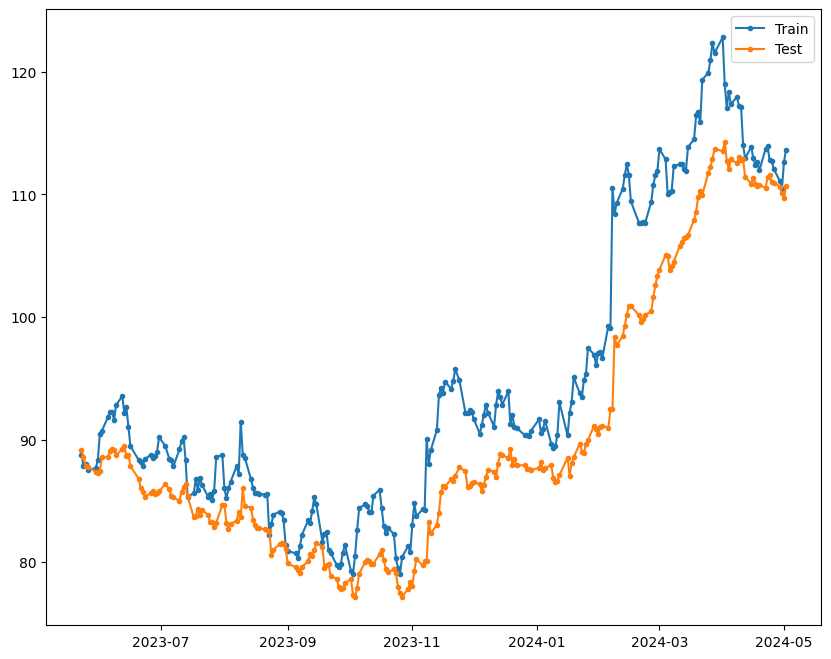

In [148]:
  
plt.figure(figsize=(10, 8)) 
#plt.plot(X_train.index, y_train) 
plt.plot(X_test.index, y_test, marker = ".") 
plt.plot(X_test.index, predictions, marker = ".") 
plt.legend(['Train', 'Test', 'Predictions']) 



## Calculating Accuracy based on if model predicts correct direction of movement

In [149]:
correct = 0

x_vals= X_test["Close"].values
y_vals = y_test.values


i = 0
for i in range(len(x_vals)):
    real_movement = x_vals[i] - y_vals[i]
    predicted_movement = x_vals[i] - predictions[i]
    if (real_movement > 0 and predicted_movement > 0) or (real_movement < 0 and predicted_movement < 0):
        correct += 1

print("% Correct: " + str(100 * correct/len(predictions)))


% Correct: 47.89915966386555
